### TTIC 31020 Introduction to Statistical Machine Learning: SVMs via sub-gradient descent and quadratic programming
---
**Colab Instructions**

You will need access to Google Drive for this; if you don't have it, let us know and we will figure out how to proceed. Also, when you make a copy, it will probably be saved in some default location; you can then move it wherever you like. When you open the notebook, tell Google to open it with Colab.

**About Colab**

Colab is essentially an online version of Jupyter. The functionality is essentially the same, but we get the added benefit of some nicer UI elements and a remote runtime. In particular, none of this code will run on your local machine (unless you explicitly ask Colab to connect to a local runtime), and all the datasets are hosted remotely.

**Introduction**

This exact version of the notebook is read-only, so you'll need to copy this into your Drive (File -> Save a copy in Drive) and modify that version.

There are two implementation parts to this exercise.

**Linear SVM**

You will start by implementing a linear SVM using subgradient descent on the primal form. Recall that we can write this as:
You will start by implementing a linear SVM using subgradient descent on the primal form. Recall that we can write this as:
\begin{equation*}
    \mathbf{w}^\ast,b^\ast = \arg\!\min \frac{1}{2} \lVert w \rVert^2 + C\sum_{i=1}^N [~ 1 -  y_i(\mathbf{w} \cdot \mathbf{x} +b)~]_+
\end{equation*}
Your task here is to implement subgradient descent to calculate an approximation to $\mathbf{w}^*$.

**Kernel SVM**

Next, you're going to implement a kernel SVM and test a few kernels on some sanity checks. You will use the _dual_ formulation of the kernel SVM that's in the lecture slides.

Once you express the QP for the dual kernel SVM problem in its canonical form, you will plug this into a black-box convex program solver called $\texttt{cvxopt}$. You will find more specific instructions in the relevant cell.

**Evaluation**

To check that your code does the right thing, we've included a few synthetic tasks and visualizations. Your code should run pretty fast on these synthetic examples, so you can make changes and iterate quickly.

Then, you will test your code on a text classification task; see the relevant cells for more details. **You should get at least 70% test accuracy on the test classification task.**

**Exporting for Kaggle**

Run the final cell to export the csv file containing your test outputs; then, upload this to Kaggle.

**Submission**

Please paste a link to your notebook in your assignment and set the sharing settings such that anyone with the link can view your notebook.

**Before coding**

Before you start writing the code for this assignment, you may find it helpful to first handwrite the gradient descent update step. 

Similarly, you might find it helpful to first handwrite the QP corresponding to the dual kernel SVM problem before coding this up so that you can keep track of all the variables in the problem.

In [ ]:
#@title Imports and test code. 
#@markdown Double click here to see exactly what the code's doing.

import numpy as np
import numpy.random as npr

import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt

import csv
import cvxopt

def create_submission_file(fname, preds):
    """Create Kaggle submision with predictions written as a csv file
    """
    ofile  = open(fname, "w")  
    writer = csv.writer(
        ofile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL
    )
    writer.writerow(['id', 'category'])
    for i in range(preds.shape[0]):
        writer.writerow([i, preds[i]])


def plot_decision_countour(svm, X, y, grid_size=100):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                         np.linspace(y_min, y_max, grid_size),
                         indexing='ij')
    data = np.stack([xx, yy], axis=2).reshape(-1, 2)
    pred = svm.predict(data).reshape(xx.shape)
    plt.contourf(xx, yy, pred,
                 cmap=cm.Paired,
                 levels=[-0.001, 0.001],
                 extend='both',
                 alpha=0.8)
    flatten = lambda m: np.array(m).reshape(-1,)
    plt.scatter(flatten(X[:,0][y==-1]),flatten(X[:,1][y==-1]),
                  c=flatten(y)[y==-1],cmap=cm.Paired,marker='o')
    plt.scatter(flatten(X[:,0][y==1]),flatten(X[:,1][y==1]),
                  c=flatten(y)[y==1],cmap=cm.Paired,marker='+')
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.plot()




def test_SVM(svm, num_samples=500,linear=False):
    """test svm
    """
    np.random.seed(783923)

    X = npr.random((num_samples, 2)) * 2 - 1
    if linear:
      y = 2 * (X.sum(axis=1) > 0) - 1.0
    else: 
      y = 2 * ((X ** 2).sum(axis=1) - 0.5 > 0) - 1.0
    svm.fit(X,y)
    
    plot_decision_countour(svm, X, y)

    from datetime import datetime
    np.random.seed(int(round(datetime.now().timestamp())))

def compute_acc(model, X, y):
    pred = model.predict(X)
    size = len(y)
    num_correct = (pred == y).sum()
    acc = num_correct / size
    print("{} out of {} correct, acc {:.3f}".format(num_correct, size, acc))

In [ ]:
#@title Linear SVM class **(To be modified)**
#@markdown This class contains a shell of an implementation of a linear SVM.
#@markdown Double click to expand and see what needs to be implemented.

class LinearSVM():
    def __init__(self,C):
        """initialize the svm
        
        Args:
            C: weight associated with the hinge loss term in the SVM loss
        """
        self.w = None
        self.bias = None
        self.C = C

    def fit(self, X, y,num_epochs=30,lr_sched=lambda t: 0.1/t):
        """Fit the model on the data
        
        Args:
            X: [N x d] data matrix
            y: [N, ] array of labels
            num_epochs: number of passes over the training data we make
            lr_sched: function determining how the learning rate decays across
                      epochs
        
        Returns:
            self, in case you want to build a pipeline
        """
        assert np.ndim(X) == 2, 'data matrix X expected to be 2d'
        assert np.ndim(y) == 1, 'labels expected to be 1d'
        N, d = X.shape
        assert N == y.shape[0], 'expect [N, d] data matrix and [N] labels'

        # TODO: implement a subgradient descent
        
        #Shuffle the matrix
        shuffling_matrix = np.random.permutation(N)
        Xtr = np.take(X,shuffling_matrix,axis = 0)
        ytr = np.take(y,shuffling_matrix,axis=0)

        #set constants
        tol = 1e-4
        lam = 1/self.C
        self.w = np.zeros(d)
        self.bias = 0
        t = 0 #steps
        

        
        for i in range(num_epochs):
          for j in range(N):
            t += 1
            if (1 - ytr[j] * (self.bias + np.dot(self.w,Xtr[j,:])) ) > 0:
              grad_w = lam*self.w - ytr[j]*Xtr[j,:]
              grad_b = -ytr[j]

            else:
              grad_w = lam*self.w
              grad_b = 0
            
            old_w = self.w
            old_b = self.bias

            self.w = old_w - lr_sched(t)*grad_w/0.1/lam
            self.bias = old_b - lr_sched(t)*grad_b/0.1/lam

            if np.linalg.norm(self.w-old_w) < tol and abs(self.bias - old_b) < tol :
              break
          
          else:
            continue
          break








        print("training complete")
        return self

    def predict(self, X, binarize=True):
        """make a prediction and return either the confidence margin or label
        
        Args:
            X: [N, d] array of data or [d,] single data point
            binarize: if True, then return the label, else the confidence margin
        
        Returns:
            Either confidence margin or predicted label
        """
        if self.w is None:
            raise ValueError("go fit the data first")
        X = np.atleast_2d(X)
        assert X.shape[1] == self.w.shape[0]
        res = X.dot(self.w)
        res = res.squeeze()+self.bias
        if binarize:
            return (res > 0).astype(np.int32) * 2 - 1
        else:
            return res

    def clone(self):
        """construct a fresh copy of myself
        """
        return LinearSVM(self.lamb, self.num_epochs)

In [ ]:
#@title Kernel class. 
#@markdown This class contains a base implementation of several common
#@markdown kernels. If you want to implement custom kernels, you should do that
#@markdown here.


class Kernel(object):
    """
    A class containing all kinds of kernels.
    Note: the kernel should work for both input (Matrix, vector) and (vector, vector)
    """
    @staticmethod
    def linear():
        def f(x, y):
            return np.dot(x, y)
        return f

    @staticmethod
    def gaussian(sigma):
        def f(x, y):
            exponent = - (1/sigma**2) * np.linalg.norm((x-y).transpose(), 2, 0) ** 2
            return np.exp(exponent)
        return f

    @staticmethod
    def _poly(dimension, offset):
        def f(x, y):
            return (offset + np.dot(x, y)) ** dimension
        return f

    @staticmethod
    def inhomogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=1.0)

    @staticmethod
    def homogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=0.0)

    @staticmethod
    def hyperbolic_tangent(kappa, c):
        def f(x, y):
            return np.tanh(kappa * np.dot(x, y) + c)
        return f

In [ ]:
#@title Kernel SVM class **(To be modified)**
#@markdown In this class, you will fill in the missing functions to
#@markdown complete the implementation of the Kernel SVM. We will set up the QP
#@markdown optimization and plug it into cvxopt, a black-box convex optimization
#@markdown library for Python.

class KernelSVM(object):
    def __init__(self, kernel, C):
        """
        Build a SVM given kernel function and C

        Parameters
        ----------
        kernel : function
            a function takes input (Matrix, vector) or (vector, vector)
        C : a scalar
            balance term

        Returns
        -------
        """
        self._kernel = kernel
        self.C = C

    def fit(self, X, y):
        """
        Fit the model given data X and ground truth label y

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        -------
        """
        # Solve the QP problem to get the multipliers
        lagrange_multipliers = self._compute_multipliers(X, y)
        print(lagrange_multipliers)
        # Get all the support vectors, support weights and bias
        self._construct_predictor(X, y, lagrange_multipliers)
    
    def predict(self, X):
        """
        Predict the label given data X

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        y : 1D array
            predicted label
        """
        result = np.full(X.shape[0], self._bias) # note: intializing scores with b
        for z_i, x_i, y_i in zip(self._weights,
                                 self._support_vectors,
                                 self._support_vector_labels):
            result += z_i * y_i * self._kernel(X, x_i) # the result is \sum_i alpha_i*y_i*x_i+b
        return np.sign(result)

    def _kernel_matrix(self, X):
        """
        Get the kernel matrix.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        K : 2D array
            N x N kernel matrix, where K[i][j] = inner_product(phi(i), phi(j))
        """
        # TODO: implement
        
        N, d = X.shape

        K = np.zeros([N,N])

        for i in range(N):
          K[i] = self._kernel(X,X[i])
        
        return K 

    def _construct_predictor(self, X, y, lagrange_multipliers):
        """
        Given the data, label and the multipliers, extract the support vectors and calculate the bias

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label
        lagrange_multipliers: 1D array
            the solution of lagrange_multiplier

        Returns
        -------
        """
        support_vector_indices = \
            lagrange_multipliers > 1e-5
            
        print("SV number: ", np.sum(support_vector_indices))

        support_multipliers = lagrange_multipliers[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]

        """
        Get the bias term
        """
        # TODO: implement

        positive_vector_indices = support_vector_labels > 0
        positive_vectors = support_vectors[positive_vector_indices]
        negative_vectors = support_vectors[~positive_vector_indices]

        positive_results = np.zeros(positive_vectors.shape[0])
        negative_results = np.zeros(negative_vectors.shape[0])

        for i in range(positive_results.shape[0]):
          positive_results[i] = np.dot(support_multipliers* \
                                       support_vector_labels, \
                                self._kernel(support_vectors,\
                                        positive_vectors[i]) \
                                        )
          
        for j in range(negative_results.shape[0]):
          negative_results[j] = np.dot(support_multipliers* \
                                       support_vector_labels, \
                                self._kernel(support_vectors,\
                                        negative_vectors[j]) \
                                        )
          
        print(positive_results)
        print(negative_results)
        bias =  - ( np.amax(negative_results) + \
                   np.amin(positive_results) )/2

        self._bias=bias
        self._weights=support_multipliers
        self._support_vectors=support_vectors
        self._support_vector_labels=support_vector_labels


    def _compute_multipliers(self, X, y):
        """
        Given the data, label, solve the QP program to get lagrange multiplier.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        lagrange_multipliers: 1D array
        -------
        """
        N, d = X.shape

        K = self._kernel_matrix(X)
        """
        The standard QP solver formulation:
        min 1/2 alpha^T H alpha + f^T alpha
        s.t.
        A * alpha \coneleq a (A is former G)
        B * alpha = b
        """
        # TODO: implement. Specifically, define the H, f, A, a, B, b arguments
        # as indicated above.

        f = cvxopt.matrix(np.ones(N))
        
        y_re = np.reshape(y,[-1,1])
        H = cvxopt.matrix( np.dot(y_re,y_re.T)*K )

        A = cvxopt.matrix( np.vstack( [np.eye(N),-np.eye(N)] ))

        a = cvxopt.matrix( np.hstack( [self.C*np.ones(N) ,\
                                       np.zeros(N)] ) )

        B = cvxopt.matrix( np.reshape(y,[1,-1]) )

        b = cvxopt.matrix( np.zeros(1) )






        solution = cvxopt.solvers.qp(H, f, A, a, B, b)

        # Lagrange multipliers
        return np.ravel(solution['x'])

training complete


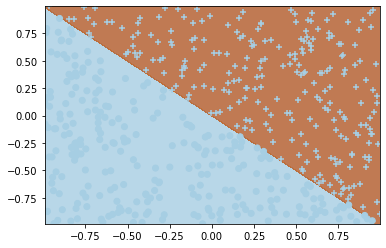

In [ ]:
#@title Linear SVM Sanity Check

svm = LinearSVM(C=10)
test_SVM(svm,linear=True)


In [ ]:
svm = KernelSVM(Kernel.linear(), C=50)
av = np.array([[1,2,3],[4,5,6],[7,8,9],[-1,2,3],[4,-5,6]])
svm._kernel_matrix(av)

array([[ 14.,  32.,  50.,  12.,  12.],
       [ 32.,  77., 122.,  24.,  27.],
       [ 50., 122., 194.,  36.,  42.],
       [ 12.,  24.,  36.,  14.,   4.],
       [ 12.,  27.,  42.,   4.,  77.]])

In [ ]:
#@title Kernel (Linear) SVM Sanity Check

svm = KernelSVM(Kernel.linear(), C=50)
test_SVM(svm,linear=True)

     pcost       dcost       gap    pres   dres
 0:  6.6086e+03 -7.9551e+05  2e+06  7e-01  1e-13
 1:  1.0373e+04 -2.0110e+05  3e+05  7e-02  1e-13
 2:  8.6993e+03 -2.5772e+04  4e+04  9e-03  2e-13
 3:  2.6619e+03 -4.6635e+03  8e+03  9e-04  7e-14
 4:  7.4102e+02 -1.3621e+03  2e+03  1e-04  2e-14
 5:  1.2965e+02 -1.4887e+02  3e+02  9e-15  1e-14
 6:  2.0942e+01 -1.2472e+01  3e+01  8e-16  4e-15
 7:  2.5950e+00 -6.5296e-01  3e+00  2e-16  2e-15
 8:  1.9287e-01 -1.4518e-02  2e-01  2e-16  7e-16
 9:  3.5287e-03 -9.3661e-05  4e-03  2e-16  7e-16
10:  3.5286e-05 -9.0176e-07  4e-05  2e-16  5e-16
11:  3.5285e-07 -9.0141e-09  4e-07  2e-16  6e-16
12:  3.5285e-09 -9.0141e-11  4e-09  2e-16  5e-16
Optimal solution found.
[3.73517804e-12 9.08319958e-12 2.27388820e-12 4.10768595e-13
 8.08554298e-13 1.62209508e-11 3.15881711e-12 8.00976755e-12
 1.94873511e-13 4.14709645e-13 6.48638172e-12 7.61641371e-12
 4.33469427e-12 7.28659817e-12 4.22387713e-13 7.43825108e-12
 7.53244039e-12 7.10832255e-13 1.39359311e-11 1

ValueError: ignored

In [ ]:
#@title Kernel (RBF) SVM Sanity Check
#feel free to play with sigma and C
svm = KernelSVM(Kernel.gaussian(sigma=0.5), C=10)
test_SVM(svm,linear=False)

In the tests above, you should have obtained images that look roughly like this:


Linear SVM

![linear SVM result](https://drive.google.com/uc?id=1XaRAcsIY1UoRq8xnLY45u01CkzGLAKuB)

Linear kernel SVM

![linear kernel result](https://drive.google.com/uc?id=1OsuPOEMjbap5M7O2fTWymNwJu7DD9fJa) 

RBF kernel SVM

![RBF kernel result](https://drive.google.com/uc?id=1tbH9STSe7p3dOxt6niJhYI17_Id7HGBY)



#### Now that our SVM is working on the toy dataset, let's do a simple sentiment analysis on [tweets on US airline service quality](https://www.kaggle.com/crowdflower/twitter-airline-sentiment/version/2). (WARNING: expletives unfiltered)
---
- As shown below, our data comes in the form of a csv table. The columns most relevant to our task are 'text' and 'airline_sentiment'.
- Data must be represented as a [N x d] matrix, but what we have on our hands is unstructured text.
- The simplest solution to transform an airline review into a vector is [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model). We maintain a global vocabulary of word patterns gathered from our corpus, with single words such as "great", "horrible", and optionally consecutive words (N-grams) like "friendly service", "luggage lost". Suppose we have already collected a total of 10000 such patterns, to transform a sentence into a 10000-dimensional vector, we simply scan it and look for the patterns that appear and set their correponding entries to 1 and leave the rest at 0. What we end up with is a sparse vector that can be fed into SVMs.
- For this exercise we use the basic text processing routines in nltk and sklearn
- Our data is not balanced, with siginificant more negatives than neutral + positives. Therefore we group neutral and positive into one category and the final ratio of non-negative vs negative is about 1:2. This is consistent across train, val and test

In [ ]:
#@markdown Here, we'll set up the dataset. To show you that this is doing
#@markdown something useful, we'll print the first three entries of the
#@markdown training set.

import os.path as osp
import pandas as pd
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer

data_root = 'data/tweets'
!curl -O https://ttic.uchicago.edu/~nsm/ttic_31020_2020/hw_3/dataset/train.csv
!curl -O https://ttic.uchicago.edu/~nsm/ttic_31020_2020/hw_3/dataset/val.csv
!curl -O https://ttic.uchicago.edu/~nsm/ttic_31020_2020/hw_3/dataset/test_release.csv

data_root = ''
train, val, test = \
    pd.read_csv(osp.join(data_root, 'train.csv')), \
    pd.read_csv(osp.join(data_root, 'val.csv')), \
    pd.read_csv(osp.join(data_root, 'test_release.csv'))

print(train.head(3))

print(train.airline_sentiment.value_counts())

In [ ]:
#@title Vectorizing the vocabulary
#@markdown Here, we build the vocabulary and vector representations for each
#@markdown word. You may find it useful to modify parts of this later, but it's
#@markdown not strictly necessary. We then sample some of the learned
#@markdown vocabulary.

# check these out 
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
def tokenize_normalize(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ", tweet)
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

# the sklearn vectorizer scans our corpus, build the vocabulary, and changes text into vectors
vectorizer = CountVectorizer(
    strip_accents='unicode', 
    lowercase=True, 
    tokenizer=tokenize_normalize,
    ngram_range=(1,1),  # you may want to try 2 grams. The vocab will get very large though,
    min_df=100,  # this parameter deletes words that occur in less than min_df
                # documents. decreasing this will increase the vocabulary size,
                # but may also increase the runtime.
)
# first learn the vocabulary
vectorizer.fit(pd.concat([train, val]).text)


print( list(vectorizer.vocabulary_.items())[:10] )
print("\n vocabulary size {}".format(len(vectorizer.vocabulary_)))

In [ ]:
#@title Setting up the training set
#@markdown Now, we will prepare the training data so that we can call our
#@markdown SVM as a black-box.

X = {}
y = {}
X['train'] = vectorizer.transform(train.text).toarray()
X['val'] = vectorizer.transform(val.text).toarray()
X['test'] = vectorizer.transform(test.text).toarray()

# note that our data is 10250 dimensional. 
# This is a little daunting for laptops and coming up with a manageable vector
# representation is a major topic in Natural Language Processing.
print(X['train'].shape)

# convert the word labels of 'positive', 'neutral', 'negative' into integer labels
# note that positive and neural belong to one category, labelled as 1, while negative stands alone as the other
for name, dataframe in zip(['train', 'val'], [train, val]):
    sentiments_in_words = dataframe['airline_sentiment'].tolist()
    int_lbls = np.array( list(map(lambda x: -1 if x == 'negative' else 1, sentiments_in_words)), dtype=np.int32 )
    y[name] = int_lbls

In [ ]:
#@title Linear SVM on the airline dataset

svm = LinearSVM(C=1000)
svm.fit(X['train'], y['train'],lr_sched=lambda t: 1/(.1*t), num_epochs=10)
compute_acc(svm, X['train'], y['train'])
compute_acc(svm, X['val'], y['val'])


In [ ]:
#@title Kernel SVM with linear kernel on the airline dataset (optional)
#@markdown This could take a while to run.

print(X['train'].shape)

svm = KernelSVM(Kernel.linear(), C=100)
svm.fit(X['train'].astype(float), y['train'].astype(float))
compute_acc(svm, X['train'], y['train'])
compute_acc(svm, X['val'], y['val'])

In [ ]:
#@title Kernel SVM with RBF kernel on the airline dataset (optional)
#@markdown This could take a while to run.

print(X['train'].shape)

svm = KernelSVM(Kernel.gaussian(sigma=1), C=10)
svm.fit(X['train'].astype(float), y['train'].astype(float))
compute_acc(svm, X['train'], y['train'])
compute_acc(svm, X['val'], y['val'])

- Try to come up with a better text feature representation. We threw out all the emojis. >< what a waste
- Play around with different parameter settings and upload your test set predictions to kaggle.
- Given the high feature dimensionality of our primitive text processing, we do not recommend using kernel SVM here. It could take a long time to train. If you reduce the feature dimensionality, then it's a different story

In [ ]:
#@title Generate test output
#@markdown Run this cell to generate the csv containing your test outputs for
#@markdown Kaggle.
#@markdown Contest link: https://www.kaggle.com/c/ttic31020hw3

test_pred = svm.predict(X['test'])
create_submission_file('tweet_test.csv', test_pred)
from google.colab import files
files.download('tweet_test.csv') 